## Get started

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# Inspect the test
import pandas as pd
import numpy as np

# rootf = '/home/barbara/Barbara_Bravi' ## Your folder
from scipy.optimize import fsolve
import os
import math
rootf = os.getcwd()
import sys
sys.path.append('/home/barbara/.local/lib/python3.9/site-packages/')
sys.path.append(rootf + '/rbm/Barbara_utils/')
sys.path.append(rootf + '/source/')
sys.path.append(rootf + '/utilities/')
# from butils import calculate_error
 # Set the number of cores. Must be executed before importing numpy&numba.
import numpy as np
import bm
import pandas as pd
# from scipy import stats
from scipy.optimize import fsolve
import math

def convert_GaussianRBM_to_BM(RBM):
    assert RBM.hidden == 'Gaussian'
    N = RBM.n_v
    nature = RBM.visible
    n_c = RBM.n_cv
    BM = bm.BM(N=N,nature=nature,n_c=n_c)
    
    if not nature in ['Bernoulli','Spin','Potts']:
        print('Boltzmann Machine %s not supported'%nature)
        return
    
    if nature == 'Bernoulli':
        couplings_BM = np.dot(RBM.weights.T, 1.0/RBM.hlayer.gamma[:,np.newaxis] *  RBM.weights)        
        fields_BM = RBM.vlayer.fields - np.dot(RBM.hlayer.theta/RBM.hlayer.gamma,RBM.weights)    + 0.5 * couplings_BM[np.arange(N),np.arange(N)]
        couplings_BM[np.arange(N),np.arange(N)] *= 0 # Important: Must have zero diagonal.
    elif nature == 'Spin':
        couplings_BM = np.dot(RBM.weights.T,1.0/RBM.hlayer.gamma[:,np.newaxis] * RBM.weights)        
        couplings_BM[np.arange(N),np.arange(N)] *= 0 # Important: Must have zero diagonal.        
        fields_BM = RBM.vlayer.fields - np.dot(RBM.hlayer.theta/RBM.hlayer.gamma,RBM.weights)
    elif nature == 'Potts':
        couplings_BM = (1.0/RBM.hlayer.gamma[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis] *  RBM.weights[:,np.newaxis,:,np.newaxis,:] * RBM.weights[:,:,np.newaxis,:,np.newaxis]).sum(0)
        fields_BM = RBM.vlayer.fields - np.tensordot(RBM.hlayer.theta/RBM.hlayer.gamma,RBM.weights,axes=[(0),(0)]) + 0.5 * couplings_BM[np.arange(N),np.arange(N)][:,np.arange(n_c),np.arange(n_c)]
        couplings_BM[np.arange(N),np.arange(N)] *= 0 # Important: Must have zero diagonal.
    
    
    BM.layer.fields = fields_BM
    BM.layer.fields0 = RBM.vlayer.fields0
    BM.layer.couplings = couplings_BM
    return BM




c:\Users\XTM23\Documents\antiberta/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
c:\Users\XTM23\Documents\antiberta/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights


### Set vacobulary and tokenizer

In [38]:
aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
vocab = {aa[k]: k for k in range(len(aa))}
keys = vocab.keys()
vocab_inv = {vocab[k]: k for k in keys}


In [5]:
## Given the vocabulary and the aligned seqs, estimate a PWM ##
curr_int = np.int16
def convert_number(seqs, vocab): # convert to numbers already aligned seqs
    
    aadict = dict(vocab)
    #aadict.update({'-':len(vocab)})
    
    msa_num = np.array(list(map(lambda x: [aadict[y] for y in x], seqs[0:])), dtype=curr_int, order="c") ### Here change ####
    
    return msa_num

def convert_letter(seqs_n, vocab_inv): # convert to numbers already aligned seqs
    #vocab_inv.update({len(vocab_inv):'-'})
    
    aadictinv = dict(vocab_inv)
    seqs=[]
    if type(seqs_n[0]) == curr_int:
        seqs.append(''.join([aadictinv[e] for e in seqs_n]))
    else:
        for t in range(len(seqs_n)):
            seqs.append(''.join([aadictinv[e] for e in seqs_n[t]]))
    return seqs

curr_float = np.float32
def average_C(config, q):
    B = config.shape[0]
    N = config.shape[1]
    out = np.zeros((N, q), dtype=curr_float)
    for b in range(B):
        for n in range(N):
            out[n, config[b, n]] += 1
    out /= B
    return out

def regularized_pwm(emp_freqsF, l2, pc):
    
    fields=[]
    pwmi=[]
    for ff in range(len(emp_freqsF)):
        def equations(x):
            return [(math.exp(x[i])/sum([math.exp(x[i]) for i in range(len(x))]) + l2*x[i] - emp_freqs[i]) for i in range(len(x))]
        emp_freqs = np.copy(emp_freqsF[ff])
        init = [np.log(c + pc) for c in emp_freqs]
        fields0 = fsolve(equations, init)
        pwmi0 = [math.exp(fields0[j])/sum([math.exp(fields0[i]) for i in range(len(fields0))]) for j in range(len(fields0))]
        
        fields.append(list(fields0))
        pwmi.append(pwmi0)
        
    fields=np.array(fields)
    pwmi=np.array(pwmi)
        
    return (fields, pwmi)

In [2]:
'''
import tensorflow as tf 
tf.random.set_seed(5);
h_or = np.array(tf.random.normal([165,21], 0, 1, tf.float32, seed=1))
J_or = np.array(tf.random.normal([165,165,21,21], 0, 1, tf.float32, seed=1))

Mb = len(seqs_al_n)
l2f = 1/Mb

n_v = seqs_al_n.shape[1] # Number of visible units = # sites in alignment.
n_c=21
nature = 'Potts'
BM1 = bm.BM(N=n_v,nature=nature,n_c=n_c)
BM1.layer.couplings = np.copy(J_or)
BM1.layer.fields = np.copy(h_or)

configs = BM1.gen_data(Nchains=2,Lchains=5000,Nstep=20,Nthermalize=1000)

seqs_al_n2=np.copy(configs)
Mb = len(seqs_al_n2)
l2f = 1/Mb

n_v = seqs_al_n2.shape[1] # Number of visible units = # sites in alignment.
n_c=21
nature = 'Potts'

BM = bm.BM(N=n_v,nature=nature,n_c=n_c)
BM.fit(seqs_al_n2, batch_size=1000, l2_fields=l2f,n_iter=100)
#batch_size=100, nchains=100, learning_rate=None, extra_params=None, init='independent', optimizer='SGD', N_PT=1, N_MC=1, n_iter=10,
#lr_decay=True, lr_final=None, decay_after=0.5, l1=0, l1b=0, l1c=0, l2=0, l2_fields=0, no_fields=False, batch_norm=False,
# update_betas=None, record_acceptance=None, epsilon=1e-6, verbose=1, record=[], record_interval=100, p=[1, 0, 0], pseudo_count=0, weights=None)
'''

"\nimport tensorflow as tf \ntf.random.set_seed(5);\nh_or = np.array(tf.random.normal([165,21], 0, 1, tf.float32, seed=1))\nJ_or = np.array(tf.random.normal([165,165,21,21], 0, 1, tf.float32, seed=1))\n\nMb = len(seqs_al_n)\nl2f = 1/Mb\n\nn_v = seqs_al_n.shape[1] # Number of visible units = # sites in alignment.\nn_c=21\nnature = 'Potts'\nBM1 = bm.BM(N=n_v,nature=nature,n_c=n_c)\nBM1.layer.couplings = np.copy(J_or)\nBM1.layer.fields = np.copy(h_or)\n\nconfigs = BM1.gen_data(Nchains=2,Lchains=5000,Nstep=20,Nthermalize=1000)\n\nseqs_al_n2=np.copy(configs)\nMb = len(seqs_al_n2)\nl2f = 1/Mb\n\nn_v = seqs_al_n2.shape[1] # Number of visible units = # sites in alignment.\nn_c=21\nnature = 'Potts'\n\nBM = bm.BM(N=n_v,nature=nature,n_c=n_c)\nBM.fit(seqs_al_n2, batch_size=1000, l2_fields=l2f,n_iter=100)\n#batch_size=100, nchains=100, learning_rate=None, extra_params=None, init='independent', optimizer='SGD', N_PT=1, N_MC=1, n_iter=10,\n#lr_decay=True, lr_final=None, decay_after=0.5, l1=0, l1b=0,

### Align sequences

In [6]:
## Import data ##
'''
name_fasta = 'Example_scripts_and_sequences/train_transformer.fasta'

# Read files aligned to the template
chain_type = 'H'
file = pd.read_csv('/home/barbara/anarci/' + name_fasta + '_' + chain_type+ '.csv')
fin = file.columns[-1]
init= '1'
seqs_al=[]
for i in range(len(file)):
    ss=[]
    for c in range(list(file.columns).index(init), list(file.columns).index(fin)):
        ss.append(file[file.columns[c]].values[i])
    str1 = ''
    str2 = str1.join(ss)
    seqs_al.append(str2) 
    ## aligned version - it mainly add gaps, but also makes deletions, 
    ## to have everything of the length of the template, here 165 

cols = list(file.columns)
y = cols.index('1')
imgt_num = cols[y:]

b_cdr1 = imgt_num.index('27')
e_cdr1 = imgt_num.index('38')

b_cdr2 = imgt_num.index('56')
e_cdr2 = imgt_num.index('65')

b_cdr3 = imgt_num.index('105')
e_cdr3 = imgt_num.index('118')
'''
def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    with open(filename,'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
            else:
                current_seq+=line[:-1]
                count+=1
        all_seqs.append(current_seq)
        #all_seqs=np.array(map(lambda x: [aadict[y] for y in x],all_seqs[1:]),dtype=int,order="c")
    return all_seqs    


# I aligned and prepared a set of ~3000 antibodies from SabDab
name_fasta='sabdab_heavy.txt'
seqs_al  =load_FASTA(rootf + "/"+ name_fasta)[1:]
f = open(rootf+"/sabdab_heavy_pos.txt", "r")
out = f.read()
imgt_num=out.splitlines()

## positions taken from IMGT templates ##
b_cdr1 = imgt_num.index('27')
e_cdr1 = imgt_num.index('38')

b_cdr2 = imgt_num.index('56')
e_cdr2 = imgt_num.index('65')

b_cdr3 = imgt_num.index('105')
e_cdr3 = imgt_num.index('117')

seqs=[]
for s in range(len(seqs_al)):
    seqs.append(''.join([seqs_al[s][i] for i in range(len(seqs_al[s])) if seqs_al[s][i]!='-']))
    
print('average seq length original dataset')
lens = [len(s) for s in seqs]
print(np.mean(lens))
print('average seq length aligned dataset')
lens = [len(s) for s in seqs_al]
print(np.mean(lens))
NA= int(np.mean(lens))
n_v=NA
print('length original dataset')
print(len(seqs))
print('length aligned dataset')
print(len(seqs_al))

Mb= len(seqs_al)
final_indices_al=list(np.arange(len(seqs_al)))
final_indices=list(np.arange(len(seqs)))

## PWM model ##
seqs_n = convert_number(seqs_al, vocab)
seqs_al_n=np.copy(seqs_n)

l2f = 1/Mb
emp_freqsF = average_C(seqs_n, len(vocab))
fields, pwm = regularized_pwm(emp_freqsF, l2f, l2f)

'''
pwm2=np.zeros((n_v,len(vocab)))
for p in range(n_v):
    pwm2[p,:] = pwm[p,:len(vocab)]/np.sum(pwm[p,:len(vocab)])
pwm=np.copy(pwm2)
'''

average seq length original dataset
120.88048315321042
average seq length aligned dataset
128.0
length original dataset
3146
length aligned dataset
3146


'\npwm2=np.zeros((n_v,len(vocab)))\nfor p in range(n_v):\n    pwm2[p,:] = pwm[p,:len(vocab)]/np.sum(pwm[p,:len(vocab)])\npwm=np.copy(pwm2)\n'

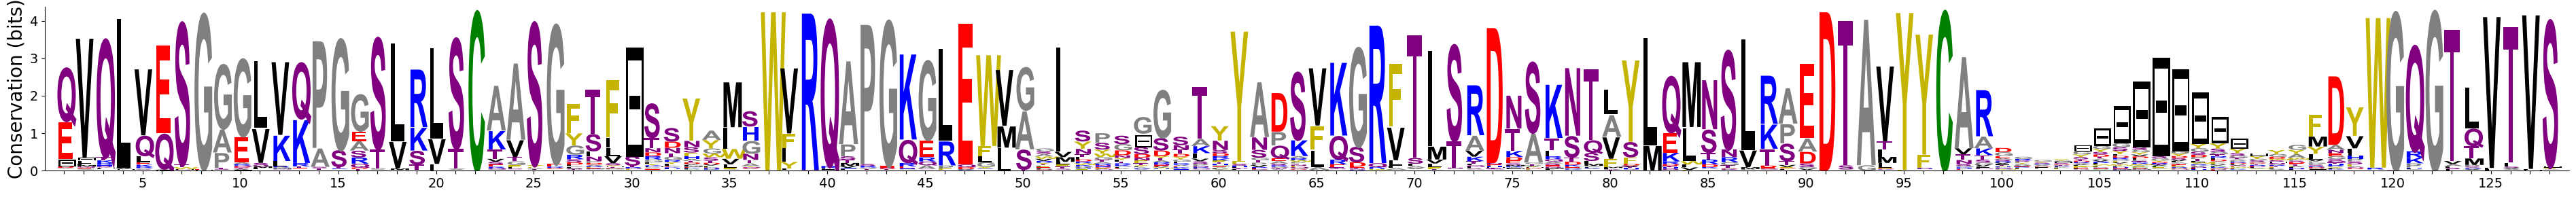

In [7]:
import utilities
import sequence_logo
fig = sequence_logo.Sequence_logo(utilities.average(seqs_al_n,c=21),  ticks_every=5) 

# TODO missing symbol as []?

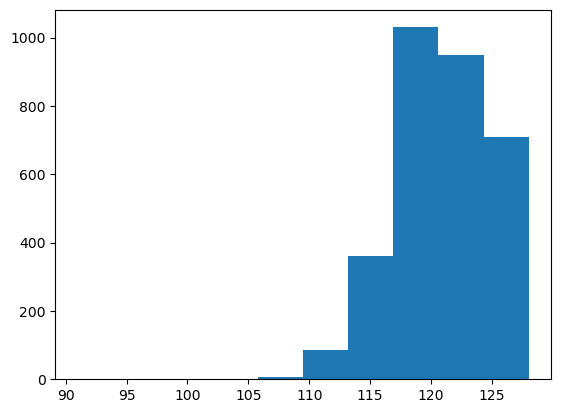

In [8]:
# distribution of sequence lengths

plt.hist([len(s) for s in seqs]);

## Train the model

In [9]:
import rbm
ZF = False ## control the introduction of fields ##
BN = True ## control batch_norm ##
RD = True ## control whether the L2 should control the top or the post field. False -> post field ##

visible = 'Potts' # Nature of visible units potential. Here, Potts states.
hidden = 'Gaussian' # Nature of hidden units potential. Here, dReLU potential.
seed = 0
decay_after = 0.5 # Decay learning rate after 50% of iterations (default: 0.5). Value for RBM shown in paper: 0.5
N_MC = 15

batch_size = 200
bb=batch_size
n_updates = int(2e4)
nn = (n_updates // (len(seqs_al_n) // bb))

n_c = len(vocab)+1
n_cv = n_c

n_hB = 25
l1bB = 0.01
vv = 1
RBM_back = rbm.RBM(visible = visible, hidden = hidden, n_v = n_v, n_h = n_hB, n_cv = n_cv, random_state = seed, zero_field=ZF)
RBM_back.fit(seqs_al_n, weights=None, l2_fields = l2f, batch_size=batch_size, n_iter=nn, l1b=l1bB, N_MC=N_MC, decay_after=decay_after, verbose=vv, vverbose=vv)
#RBM_utils.saveRBM(name_back,RBM_back)
#RBM_back = RBM_utils.loadRBM(name_back)

Iteration number 0, pseudo-likelihood: -1.12
Starting epoch 1
[RBM] Iteration 1, time = 0.63s, pseudo-likelihood = -0.91
Starting epoch 2
[RBM] Iteration 2, time = 0.65s, pseudo-likelihood = -0.89
Starting epoch 3
[RBM] Iteration 3, time = 0.61s, pseudo-likelihood = -0.84
Starting epoch 4
[RBM] Iteration 4, time = 0.61s, pseudo-likelihood = -0.82
Starting epoch 5
[RBM] Iteration 5, time = 0.66s, pseudo-likelihood = -0.79
Starting epoch 6
[RBM] Iteration 6, time = 0.59s, pseudo-likelihood = -0.78
Starting epoch 7
[RBM] Iteration 7, time = 0.64s, pseudo-likelihood = -0.75
Starting epoch 8
[RBM] Iteration 8, time = 0.62s, pseudo-likelihood = -0.80
Starting epoch 9
[RBM] Iteration 9, time = 0.60s, pseudo-likelihood = -0.74
Starting epoch 10
[RBM] Iteration 10, time = 0.64s, pseudo-likelihood = -0.74
Starting epoch 11
[RBM] Iteration 11, time = 0.64s, pseudo-likelihood = -0.74
Starting epoch 12
[RBM] Iteration 12, time = 0.66s, pseudo-likelihood = -0.76
Starting epoch 13
[RBM] Iteration 13,

{}

In [11]:
import Proteins_utils, RBM_utils
out_par = '_niter' + str(nn) + '_batch' + str(bb) + '_HU' + str(n_hB) + '_L12' + str(l1bB)
name_back = '/home/barbara/antiberta/sabdab_heavy_RBM' + out_par +'.data'
RBM_utils.saveRBM(name_back,RBM_back)

In [12]:
from butils import calculate_error
(errmt, errct, mugen, mudata, covgen, covdata) = calculate_error(RBM_back, seqs_al_n)
print(errmt)
print(errct)

ModuleNotFoundError: No module named 'butils'

## Interpret the results

In [13]:
BM = convert_GaussianRBM_to_BM(RBM_back)

J = BM.layer.couplings
h = BM.layer.fields

ni_symb = [50] # if there is any symbol to remove from the computation of epistatic contributions
final_symbol = len(h[0])
probs = [] 
for s in final_indices_al:
    prob=[]
    for i in range(len(seqs_al_n[s])):
        #if seqs_al_n[s][i] not in ni_symb:
        #coupled = [J[i, j, seqs_al_n[s][i], seqs_al_n[s][j]] for j in range(len(seqs_al_n[s])) if j!=i and seqs_al_n[s][j] not in ni_symb]
        coupled_mat = [J[i, j, :, seqs_al_n[s][j]] for j in range(len(seqs_al_n[s])) if j!=i and seqs_al_n[s][j] not in ni_symb] # TODO check dimension of coupled_mat
        zi = np.sum(np.exp(h[i, :final_symbol] + np.sum(coupled_mat, axis=0)))
        prob.append(np.exp(h[i, :final_symbol] + sum(coupled_mat))/zi)
    probs.append(prob)

In [30]:
import pickle

# Open a file and use dump()
with open('coupling.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(J, file)

with open("field.pkl", "wb") as file:
    pickle.dump(h, file)

In [33]:
with open("prob.pkl", "wb") as file:
    pickle.dump(probs, file)

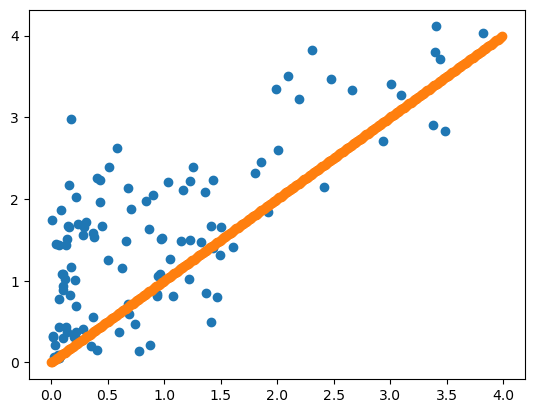

In [14]:
'''
ref = 190
entropies_t=[]
entropies_p=[]
for i in range(NA):
    if seqs_al[ref][i] !='-':
        entropies_t.append(sum(-(probs[ref][i][:])*np.log2(probs[ref][i][:])))
        entropies_p.append(sum(-pwm[i,:]*np.log2(pwm[i,:]))) ## these are all the same

plt.scatter(entropies_t, entropies_p)
plt.scatter(np.arange(0,4,0.01),np.arange(0,4,0.01))
'''
entropies_t=[]
entropies_p=[]
mapping_indices_seq=[]
for s in range(len(final_indices)):
    #token_ids = tokenizer.encode(seqs[final_indices[s]], return_tensors='pt')

    seq1 = seqs[final_indices[s]]
    seq2 = seqs_al[final_indices_al[s]]

    #print(seq1)
    #print(seq2)

    indices_al = []
    i = 0
    j = 0
    while i < len(seq1) and j < len(seq2):
        if seq1[i] == seq2[j]:
            indices_al.append(j)
            i += 1
        j += 1

    ## Check consistent def of indices ##
    list1=[]
    list2=[]
    for i in range(len(seqs[final_indices[s]])):
        list1.append(seqs[final_indices[s]][i])
        #print(indices_al[i])
        ip = indices_al[i]
        list2.append(seqs_al[final_indices_al[s]][ip])
    #plt.scatter(list1,list2)

    
    ## single-sequence, single-site entropy ##
    ent_t = [] 
    ent_p = [] 
    #mapping_indices=[]
    c=0
    #uu=[]
    for i in range(len(seqs_al[final_indices_al[s]])):
        ## position ##
        #a = int(token_ids.squeeze()[i])
        #a = vocab[seqs_al[final_indices_al[s]][i]]
        #uu.append(a)
        ent_t.append(sum(-(probs[s][i][:])*np.log2(probs[s][i][:])))
        #mapping_indices.append(indices_al[c])
        #ip = indices_al[c]
        ip=i
        #c+=1
        #sym = seqs_al[final_indices_al[s]][ip]
        #a = vocab[sym]
        ent_p.append(sum(-pwm[ip,:]*np.log2(pwm[ip,:])))
    
    entropies_t.append(ent_t)
    entropies_p.append(ent_p)
    mapping_indices_seq.append(indices_al)
    #plt.plot(np.array(ent_p) - np.array(ent_t))
    
ref=10
vec1=[entropies_t[ref][i] for i in range(len(seqs_al[ref])) if seqs_al[ref][i] != '-']
vec2=[entropies_p[ref][i] for i in range(len(seqs_al[ref])) if seqs_al[ref][i] != '-']
plt.scatter(vec1,vec2)
plt.scatter(np.arange(0,4,0.01),np.arange(0,4,0.01))

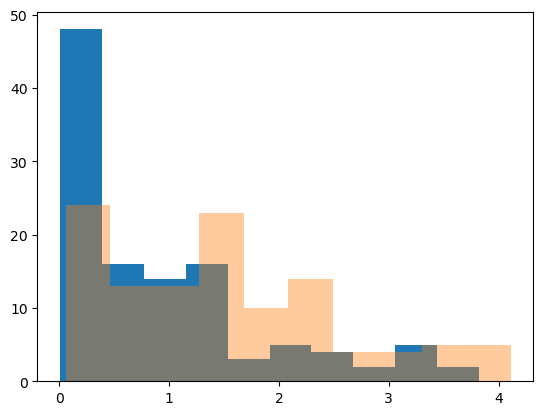

In [15]:
plt.hist(vec1);
plt.hist(vec2,alpha=0.4);

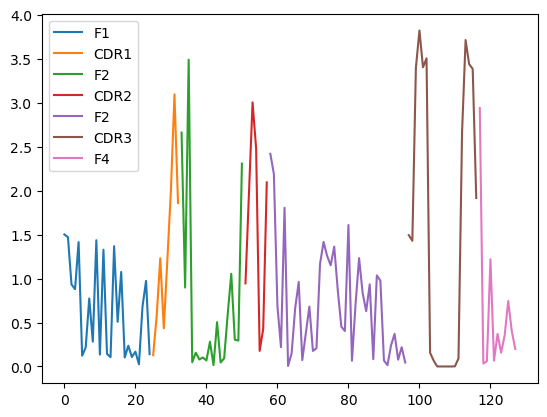

In [16]:
ref=10
ent_p_al = np.array(entropies_t[ref])
import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1), ent_p_al[:b_cdr1], label='F1')
plt.plot(np.arange(b_cdr1,e_cdr1), ent_p_al[b_cdr1:e_cdr1], label='CDR1')
plt.plot(np.arange(e_cdr1, b_cdr2), ent_p_al[e_cdr1: b_cdr2], label='F2')
plt.plot(np.arange(b_cdr2,e_cdr2), ent_p_al[b_cdr2:e_cdr2], label='CDR2')
plt.plot(np.arange(e_cdr2, b_cdr3), ent_p_al[e_cdr2: b_cdr3], label='F2')
plt.plot(np.arange(b_cdr3,e_cdr3), ent_p_al[b_cdr3:e_cdr3], label='CDR3')
plt.plot(np.arange(e_cdr3, NA), ent_p_al[e_cdr3:], label='F4')
plt.legend()

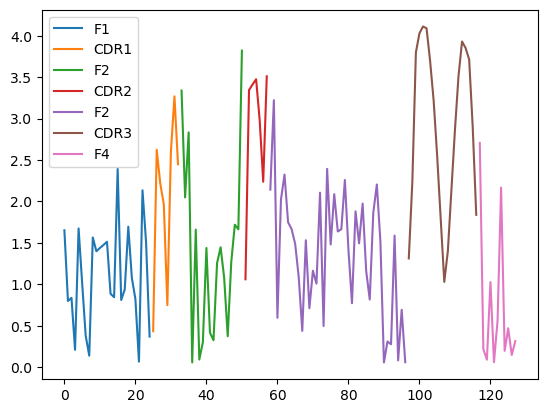

In [17]:
ent_p_al = np.array(entropies_p[ref])
import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1), ent_p_al[:b_cdr1], label='F1')
plt.plot(np.arange(b_cdr1,e_cdr1), ent_p_al[b_cdr1:e_cdr1], label='CDR1')
plt.plot(np.arange(e_cdr1, b_cdr2), ent_p_al[e_cdr1: b_cdr2], label='F2')
plt.plot(np.arange(b_cdr2,e_cdr2), ent_p_al[b_cdr2:e_cdr2], label='CDR2')
plt.plot(np.arange(e_cdr2, b_cdr3), ent_p_al[e_cdr2: b_cdr3], label='F2')
plt.plot(np.arange(b_cdr3,e_cdr3), ent_p_al[b_cdr3:e_cdr3], label='CDR3')
plt.plot(np.arange(e_cdr3, NA), ent_p_al[e_cdr3:], label='F4')
plt.legend()

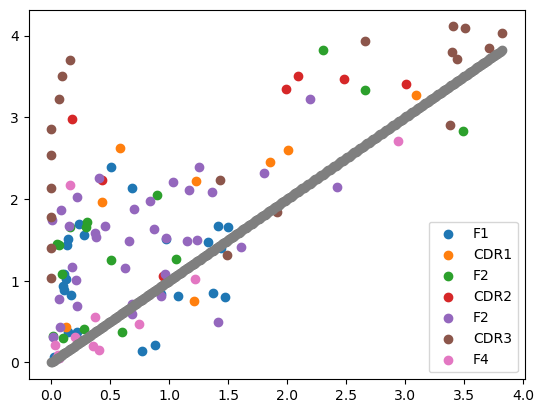

In [18]:
vec1=list(entropies_t[ref])
vec2=list(entropies_p[ref])

plt.scatter(vec1[:b_cdr1], vec2[:b_cdr1], label='F1')
plt.scatter(vec1[b_cdr1:e_cdr1], vec2[b_cdr1:e_cdr1], label='CDR1')
plt.scatter(vec1[e_cdr1: b_cdr2], vec2[e_cdr1: b_cdr2], label='F2')
plt.scatter(vec1[b_cdr2:e_cdr2], vec2[b_cdr2:e_cdr2], label='CDR2')
plt.scatter(vec1[e_cdr2: b_cdr3], vec2[e_cdr2: b_cdr3], label='F2')
plt.scatter(vec1[b_cdr3:e_cdr3], vec2[b_cdr3:e_cdr3], label='CDR3')
plt.scatter(vec1[e_cdr3:], vec2[e_cdr3:], label='F4')
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))
plt.legend()

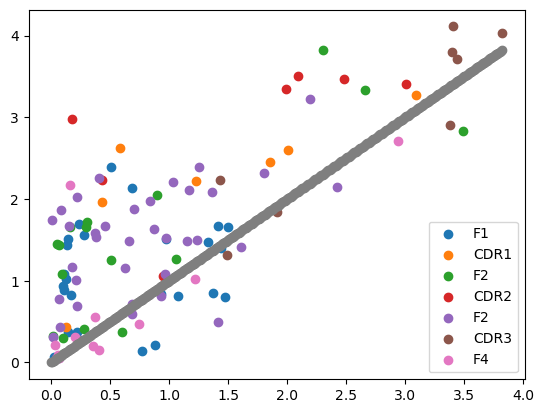

In [19]:
## Now same plot but without gaps, need mapping the positions 
## in aligned and unaligned sequences ##

b_cdr1n = mapping_indices_seq[ref].index(b_cdr1)
e_cdr1n = mapping_indices_seq[ref].index(e_cdr1)
b_cdr2n = mapping_indices_seq[ref].index(b_cdr2)
e_cdr2n = mapping_indices_seq[ref].index(e_cdr2)
b_cdr3n = mapping_indices_seq[ref].index(b_cdr3)
e_cdr3n = mapping_indices_seq[ref].index(e_cdr3)

vec1=[entropies_t[ref][i] for i in range(len(seqs_al[ref])) if seqs_al[ref][i] != '-']
vec2=[entropies_p[ref][i] for i in range(len(seqs_al[ref])) if seqs_al[ref][i] != '-']

plt.scatter(vec1[:b_cdr1n], vec2[:b_cdr1n], label='F1')
plt.scatter(vec1[b_cdr1n:e_cdr1n], vec2[b_cdr1n:e_cdr1n], label='CDR1')
plt.scatter(vec1[e_cdr1n: b_cdr2n], vec2[e_cdr1n: b_cdr2n], label='F2')
plt.scatter(vec1[b_cdr2n:e_cdr2n], vec2[b_cdr2n:e_cdr2n], label='CDR2')
plt.scatter(vec1[e_cdr2n: b_cdr3n], vec2[e_cdr2n: b_cdr3n], label='F2')
plt.scatter(vec1[b_cdr3n:e_cdr3n], vec2[b_cdr3n:e_cdr3n], label='CDR3')
plt.scatter(vec1[e_cdr3n:], vec2[e_cdr3n:], label='F4')
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))
plt.legend()

In [20]:
# if we want to get CDE for each position only - averaging over the 
# possible contexts 

## Finally, for each position, summing over possible symbols
## in a way which is conditional or unconditional on the rest of the sequence
## we get the CDE and the CIE
NA=n_v
cie=[]
cde=[]
for i in range(n_v): ## for each position, we sum over the sequences that have that position ##
    #relevant_seq = [s for s in range(len(seqs)) if i in mapping_indices_seq[s]]
    relevant_seq=np.arange(len(seqs))
    if len(relevant_seq)>0:
        ep=0
        et=0
        for s in relevant_seq:
            #j = mapping_indices_seq[s].index(i)
            #ep+=entropies_p[s][j]
            #et+=entropies_t[s][j]
            ep+=entropies_p[s][i]
            et+=entropies_t[s][i]
        cie.append(ep/len(relevant_seq))
        cde.append(et/len(relevant_seq))
    else:
        cie.append(0)
        cde.append(0)

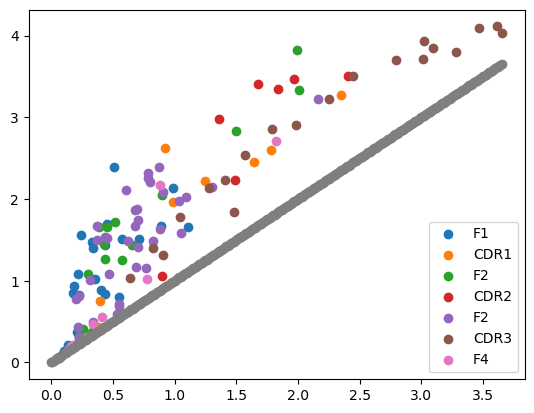

In [21]:
vec1=list(cde)
vec2=list(cie)

plt.scatter(vec1[:b_cdr1], vec2[:b_cdr1], label='F1')
plt.scatter(vec1[b_cdr1:e_cdr1], vec2[b_cdr1:e_cdr1], label='CDR1')
plt.scatter(vec1[e_cdr1: b_cdr2], vec2[e_cdr1: b_cdr2], label='F2')
plt.scatter(vec1[b_cdr2:e_cdr2], vec2[b_cdr2:e_cdr2], label='CDR2')
plt.scatter(vec1[e_cdr2: b_cdr3], vec2[e_cdr2: b_cdr3], label='F2')
plt.scatter(vec1[b_cdr3:e_cdr3], vec2[b_cdr3:e_cdr3], label='CDR3')
plt.scatter(vec1[e_cdr3:], vec2[e_cdr3:], label='F4')
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))
plt.legend()

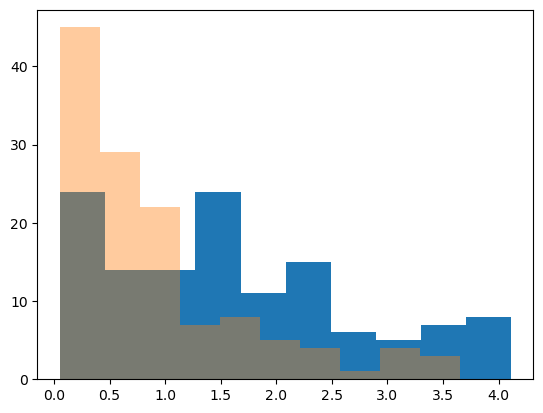

In [22]:
plt.hist(cie);
plt.hist(cde, alpha=0.4);

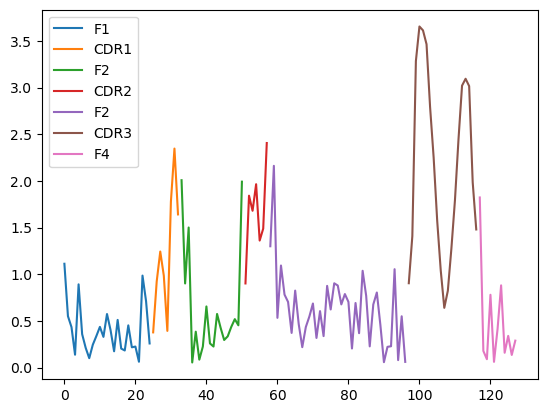

In [23]:
ent_p_al = np.array(cde)
import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1), ent_p_al[:b_cdr1], label='F1')
plt.plot(np.arange(b_cdr1,e_cdr1), ent_p_al[b_cdr1:e_cdr1], label='CDR1')
plt.plot(np.arange(e_cdr1, b_cdr2), ent_p_al[e_cdr1: b_cdr2], label='F2')
plt.plot(np.arange(b_cdr2,e_cdr2), ent_p_al[b_cdr2:e_cdr2], label='CDR2')
plt.plot(np.arange(e_cdr2, b_cdr3), ent_p_al[e_cdr2: b_cdr3], label='F2')
plt.plot(np.arange(b_cdr3,e_cdr3), ent_p_al[b_cdr3:e_cdr3], label='CDR3')
plt.plot(np.arange(e_cdr3, NA), ent_p_al[e_cdr3:], label='F4')
plt.legend()